core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:53:44.819' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_d

Sample lap data:
  Driver                LapTime Compound  TyreLife TrackStatus
1    VER 0 days 00:01:19.367000   MEDIUM       2.0           1
2    VER 0 days 00:01:19.074000   MEDIUM       3.0           1
3    VER 0 days 00:01:18.129000   MEDIUM       4.0           1
4    VER 0 days 00:01:18.019000   MEDIUM       5.0           1
5    VER 0 days 00:01:17.640000   MEDIUM       6.0           1
Epoch 5, Loss: 0.4011
Epoch 10, Loss: 0.1250
Epoch 15, Loss: 0.0313
Epoch 20, Loss: 0.0284
Epoch 25, Loss: 0.0274
Epoch 30, Loss: 0.0266
Epoch 35, Loss: 0.0254
Epoch 40, Loss: 0.0246
Epoch 45, Loss: 0.0247
Epoch 50, Loss: 0.0230

Sample predictions vs actuals:
Predicted: 78.09s | Actual: 78.24s
Predicted: 78.07s | Actual: 78.36s
Predicted: 78.11s | Actual: 78.00s
Predicted: 78.14s | Actual: 78.03s
Predicted: 78.06s | Actual: 78.01s


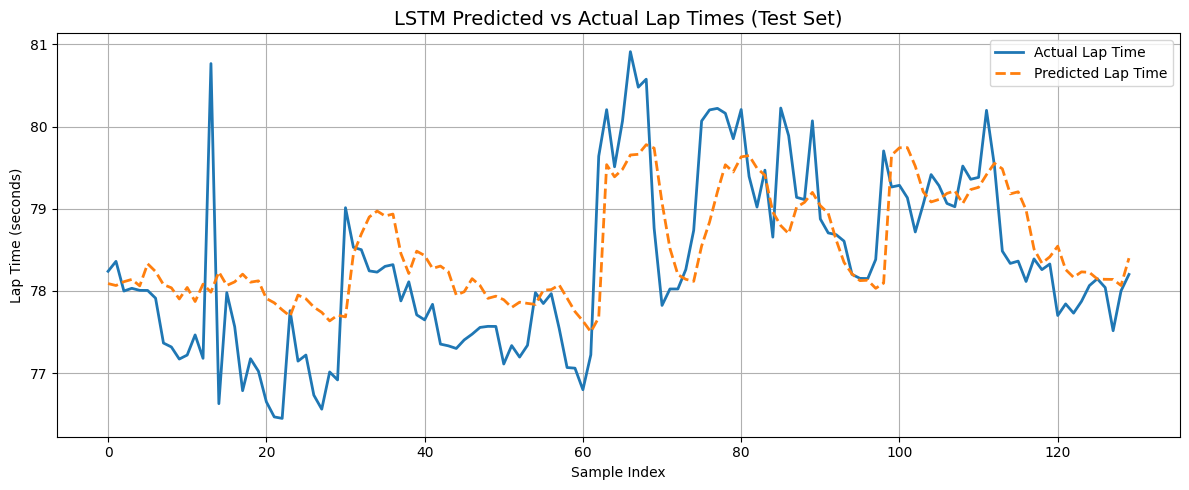


🏁 Race Simulation Summary (Model vs Actual):
  Driver  PredictedLapTime  ActualLapTime  Delta (s)
3    SAI       2417.526116    2402.128000  15.398117
1    PIA       2445.440685    2437.618001   7.822685
2    RUS       2501.069974    2486.972000  14.097974
0    BOT       2842.335796    2854.543000 -12.207204


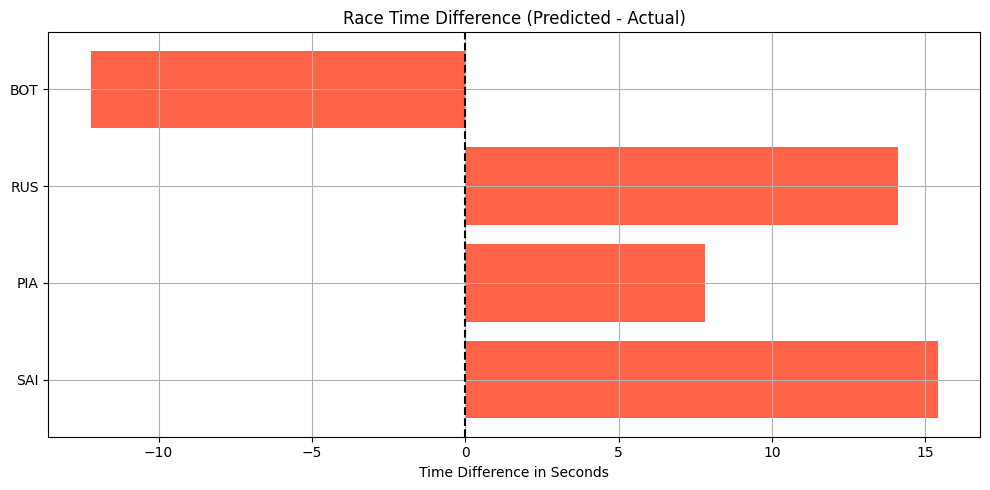

In [19]:
# 📘 F1 Prediction Project (2025 Edition)
# FastF1 + XGBoost + SHAP + LSTM (PyTorch) with full normalization

# ----------------------------------------
# 🔹 PART 1: SETUP & DEPENDENCIES
# ----------------------------------------
!pip install fastf1 xgboost shap matplotlib scikit-learn pandas --quiet

# Imports
import os
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------
# 🔹 PART 2: ENABLE CACHE & LOAD DATA
# ----------------------------------------
os.makedirs('/content/f1_cache', exist_ok=True)
fastf1.Cache.enable_cache('/content/f1_cache')

session = fastf1.get_session(2023, 'Monaco', 'R')
session.load()

laps = session.laps.pick_quicklaps().copy()
print("Sample lap data:")
print(laps[['Driver', 'LapTime', 'Compound', 'TyreLife', 'TrackStatus']].head())

# ----------------------------------------
# 🔹 PART 3: FEATURE ENGINEERING
# ----------------------------------------
columns = ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
sequence_length = 10

laps = laps[['Driver', 'LapNumber', 'LapTime'] + columns].dropna()
laps['LapTimeSec'] = laps['LapTime'].dt.total_seconds()

# Normalize inputs
feature_scaler = MinMaxScaler()
laps[columns] = feature_scaler.fit_transform(laps[columns])

# Normalize labels
label_scaler = MinMaxScaler()
laps['LapTimeSec'] = label_scaler.fit_transform(laps[['LapTimeSec']])

sequences = []
labels = []

for driver in laps['Driver'].unique():
    driver_laps = laps[laps['Driver'] == driver].sort_values('LapNumber')
    for i in range(len(driver_laps) - sequence_length):
        seq = driver_laps.iloc[i:i+sequence_length][columns].values
        label = driver_laps.iloc[i+sequence_length]['LapTimeSec']
        sequences.append(seq)
        labels.append(label)

X = torch.tensor(np.array(sequences), dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

# Split into train and test
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ----------------------------------------
# 🔹 PART 4: LSTM MODEL
# ----------------------------------------
class LapTimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(LapTimeDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(LapTimeDataset(X_test, y_test), batch_size=32, shuffle=False)

class LapPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.norm = nn.BatchNorm1d(input_size)
        self.lstm = nn.LSTM(input_size, hidden_size=64, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        _, (h_n, _) = self.lstm(x)
        return self.head(h_n[-1])

model = LapPredictor(input_size=X.shape[2])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ----------------------------------------
# 🔹 PART 5: TRAINING
# ----------------------------------------
model.train()
for epoch in range(50):
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# ----------------------------------------
# 🔹 PART 6: EVALUATION
# ----------------------------------------
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        preds.extend(pred.squeeze().tolist())
        actuals.extend(yb.squeeze().tolist())

# Inverse transform predictions
preds = label_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
actuals = label_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

print("\nSample predictions vs actuals:")
for i in range(5):
    print(f"Predicted: {preds[i]:.2f}s | Actual: {actuals[i]:.2f}s")
# ----------------------------------------
# 🔹 PART 7: PREDICTED vs ACTUAL LAP TIME PLOT
# ----------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(actuals, label="Actual Lap Time", linewidth=2)
plt.plot(preds, label="Predicted Lap Time", linestyle='--', linewidth=2)
plt.title("LSTM Predicted vs Actual Lap Times (Test Set)", fontsize=14)
plt.xlabel("Sample Index")
plt.ylabel("Lap Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------
# 🔹 PART 8: RACE SIMULATION SUMMARY (PREDICTED VS ACTUAL)
# ----------------------------------------

import pandas as pd

# ⚠️ Make sure to re-link X_test to their driver/lap context if needed.
# We'll assume each sequence is still in order of driver laps.
# Let's recreate the driver info based on lap sequences.

# Grab driver info from the raw lap dataframe
drivers = []
for driver in laps['Driver'].unique():
    driver_laps = laps[laps['Driver'] == driver].sort_values('LapNumber')
    for i in range(len(driver_laps) - sequence_length):
        drivers.append(driver)

# Match drivers to test set
driver_test = drivers[split_idx:]

# Create summary DataFrame
race_summary = pd.DataFrame({
    'Driver': driver_test[:len(actuals)],
    'PredictedLapTime': preds[:len(driver_test)],
    'ActualLapTime': actuals[:len(driver_test)]
})

# Group by driver
driver_stats = race_summary.groupby('Driver').agg({
    'PredictedLapTime': 'sum',
    'ActualLapTime': 'sum'
}).reset_index()

driver_stats['Delta (s)'] = driver_stats['PredictedLapTime'] - driver_stats['ActualLapTime']
driver_stats = driver_stats.sort_values('PredictedLapTime')

# Show table
print("\n🏁 Race Simulation Summary (Model vs Actual):")
print(driver_stats)

# Optional: Bar plot of race deltas
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.barh(driver_stats['Driver'], driver_stats['Delta (s)'], color='tomato')
plt.axvline(0, color='black', linestyle='--')
plt.title("Race Time Difference (Predicted - Actual)")
plt.xlabel("Time Difference in Seconds")
plt.grid(True)
plt.tight_layout()
plt.show()